<a href="https://colab.research.google.com/github/JingyuanWu17/DL/blob/master/hw6prob2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#(a)
from keras.datasets.fashion_mnist import load_data 

(train_X, train_y), (test_X, test_y) = load_data()

print('Train:', train_X.shape, train_y.shape)
print('Test:', test_X.shape, test_y.shape)

In [ ]:
#(b)
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense

# define the discriminator model
def discriminator():
	model = Sequential()
 
	model.add(Conv2D(64, (5,5), strides=(2, 2), padding='same', input_shape=(28,28,1)))
	model.add(LeakyReLU(alpha=0.3))
	model.add(Dropout(0.3))
 
	model.add(Conv2D(128, (5,5), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.3))
	model.add(Dropout(0.3))
 
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	return model

In [ ]:
#(c)
from keras.layers import Conv2DTranspose
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras import activations

# define the generator model
def generator():
  model = Sequential()
  
  model.add(Dense(256 * 7 * 7, input_dim=100))
  model.add(Reshape((7, 7, 256)))
 
  model.add(Conv2DTranspose(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.3))
 
  model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.3))
 
  model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.3))
  model.add(Activation(activations.tanh))
  
  return model

In [ ]:
#(d)
from keras.optimizers import Adam

def gan(g_model, d_model):

	d_model.trainable = False

	model = Sequential()

  # add generator model
	model.add(g_model)
 
  # add discriminator model
	model.add(d_model)

	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001))
 
	return model

In [ ]:
discriminator_model = discriminator()
discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [ ]:
generator_model = generator()
generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)       

In [ ]:
gan_model = gan(generator_model, discriminator_model)
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         2293505   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 212865    
Total params: 2,506,370
Trainable params: 2,293,121
Non-trainable params: 213,249
_________________________________________________________________


epoch: 10


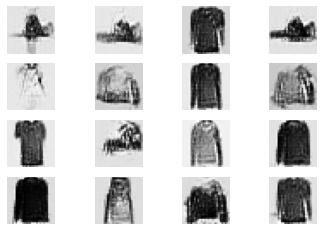

epoch: 30


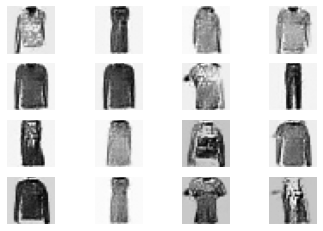

epoch: 50


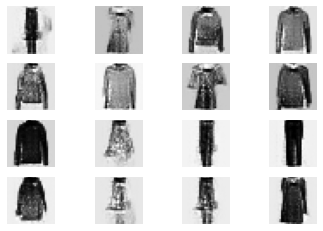

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_latent_points(latent_dim, num_samples):
	x = np.random.randn(latent_dim * num_samples)
	x = x.reshape(num_samples, latent_dim)
	return x

def load_real_samples():
  (X_train, _), (_, _) = load_data()
  X = np.expand_dims(X_train, axis=-1)
  X = X.astype('float32')
  X = X / 255.0
  return X

# train the GAN
def train(g_model, d_model, gan_model, dataset, epochs, batch_size):
  half_batch = int(batch_size / 2);
  bat_per_epo = int(dataset.shape[0] / batch_size)
  d_losses = []
  g_losses = []

  for i in range(epochs):
    d_loss_tmp = []
    g_loss_tmp = []
    for j in range(bat_per_epo):

      # generate 'real' examples
      ix = np.random.randint(0, dataset.shape[0], half_batch)
      X_real = dataset[ix]
      y_real = np.ones((half_batch, 1))

      # generate points in latent space as input for the generator
      x_input = generate_latent_points(100, half_batch)

      # use the generator to generate 'fake' samples
      X_fake = g_model.predict(x_input)
      y_fake = np.zeros((half_batch, 1))

			# training samples for the discriminator
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
   
			# update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
   
			# generate points in latent space as input for the generator
      X_gan = generate_latent_points(100, batch_size)
   
			# create inverted labels for the fake samples
      y_gan = np.ones((batch_size, 1))
   
			# update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      d_loss_tmp.append(d_loss)
      g_loss_tmp.append(g_loss)

    d_losses.append(np.average(d_loss_tmp))
    g_losses.append(np.average(g_loss_tmp))

    if i == 9 or i == 29 or i == 49:
      print("epoch:", i + 1)
      x_input = generate_latent_points(100, half_batch)
      X = g_model.predict(x_input)
      plt.figure()
      for i in range(16):
        plt.subplot(4, 4, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
      plt.show()
      

  return d_losses, g_losses

dataset = load_real_samples()

d_losses, g_losses = train(generator_model, discriminator_model, gan_model, dataset, 50, 32)
			

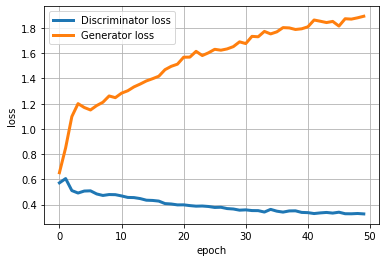

In [ ]:
#(f)
plt.plot(range(50),d_losses,'-',linewidth=3,label='Discriminator loss')
plt.plot(range(50),g_losses,'-',linewidth=3,label='Generator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Comments:<br>
As we can see, with the increase of epochs, the loss of generator increases, and the loss of discriminator decreases.<br>
Our goal is to maximize the loss of the generator and minimize the loss of the discriminator. This plot meets our expectations.<br>
So, this plot shows that both the generator and discriminator are doing better and better.